In [12]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

etfs = pd.read_csv('filtered_etfs.csv', header = None, names = ['ETF'])

tickers = etfs["ETF"].tolist()

start_date = '2015-01-01'
end_date = '2020-01-01'

prices = yf.download(tickers = tickers, start = start_date, end = end_date)['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_8660/1887220627.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers = tickers, start = start_date, end = end_date)['Close']
[*********************100%***********************]  62 of 62 completed


In [13]:
# rolling cointegration

window_size = 252
min_passes = 0.4
step = 21

candidate_pairs = []
cointegrated_pairs = []

category_prices = prices[tickers]

for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        candidate_pairs.append([tickers[i], tickers[j]])

for etf1, etf2 in candidate_pairs:
            
    df = category_prices[[etf1, etf2]].dropna()

    series1 = df.iloc[:, 0]
    series2 = df.iloc[:, 1]

    cointegrated_windows = 0
    total_windows = 0

    for start in range(0, len(df) - window_size + 1, step):
        end = start + window_size

        window_s1 = series1.iloc[start:end]
        window_s2 = series2.iloc[start:end]
                
        score, pvalue, _ = coint(window_s1, window_s2)
        total_windows += 1
                
        if pvalue < 0.1:
            cointegrated_windows += 1

    if cointegrated_windows / total_windows >= min_passes:
        cointegrated_pairs.append({'ETF1': etf1, 'ETF2': etf2, 'Pass %': cointegrated_windows / total_windows})
    print(f'ETF1: {etf1}, ETF2: {etf2}, Pass %: {cointegrated_windows / total_windows}')

cointegrated_pairs_df = pd.DataFrame(cointegrated_pairs)

cointegrated_pairs_df = cointegrated_pairs_df.sort_values('Pass %', ascending = False).reset_index(drop = True)
print(f'Rolling Cointegrated Pairs:')
print(cointegrated_pairs_df)


ETF1: IVE, ETF2: USMV, Pass %: 0.041666666666666664
ETF1: IVE, ETF2: SPYV, Pass %: 0.7291666666666666
ETF1: IVE, ETF2: SCHM, Pass %: 0.14583333333333334
ETF1: IVE, ETF2: IWS, Pass %: 0.2708333333333333
ETF1: IVE, ETF2: FV, Pass %: 0.041666666666666664
ETF1: IVE, ETF2: DVY, Pass %: 0.25
ETF1: IVE, ETF2: QQQ, Pass %: 0.20833333333333334
ETF1: IVE, ETF2: PRF, Pass %: 0.08333333333333333
ETF1: IVE, ETF2: VTI, Pass %: 0.1875
ETF1: IVE, ETF2: IJH, Pass %: 0.25
ETF1: IVE, ETF2: IUSG, Pass %: 0.1875
ETF1: IVE, ETF2: VO, Pass %: 0.0625
ETF1: IVE, ETF2: SDY, Pass %: 0.10416666666666667
ETF1: IVE, ETF2: IWB, Pass %: 0.1875
ETF1: IVE, ETF2: SPLV, Pass %: 0.041666666666666664
ETF1: IVE, ETF2: IWR, Pass %: 0.10416666666666667
ETF1: IVE, ETF2: FVD, Pass %: 0.020833333333333332
ETF1: IVE, ETF2: OEF, Pass %: 0.14583333333333334
ETF1: IVE, ETF2: HDV, Pass %: 0.0625
ETF1: IVE, ETF2: MDY, Pass %: 0.25
ETF1: IVE, ETF2: RSP, Pass %: 0.0625
ETF1: IVE, ETF2: ARKK, Pass %: 0.0625
ETF1: IVE, ETF2: SCHB, Pass %:

Clusters:
     ETF  Cluster        PC1        PC2
0    IVE        0 -11.184003  -9.162677
1   USMV        0 -25.859656   1.947520
2   SPYV        0 -10.366720  -8.808794
3   SCHM        1  10.370398  -7.751420
4    IWS        0  -1.394182 -16.839923
..   ...      ...        ...        ...
57  SPHD        0 -23.003854 -17.817845
58   DIA        0 -15.146952   3.880078
59  MTUM        0  -7.737666  25.621507
60   VYM        0 -17.973605  -5.729427
61  SPMD        1  19.770834 -16.755056

[62 rows x 4 columns]


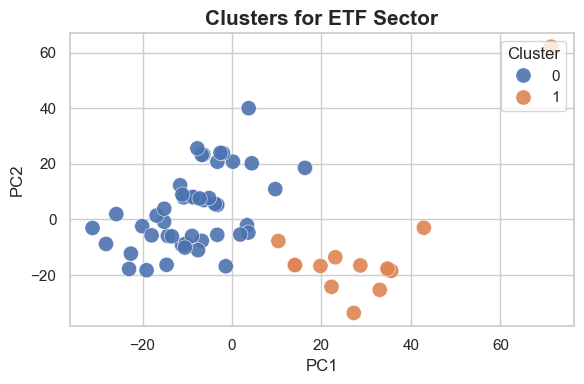

In [14]:
# k-means / PCA

category_prices = prices[tickers]

returns = category_prices.pct_change().dropna()

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns.T)

pca = PCA(n_components = 2)
pca_components = pca.fit_transform(returns_scaled)

max_clusters = min(len(etfs) - 1, 10)

best_k = 2
best_score = -1

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(pca_components)
    score = silhouette_score(pca_components, labels)

    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters = best_k, random_state = 42)
labels = kmeans.fit_predict(pca_components)

cluster_df = pd.DataFrame({
    'ETF': returns.columns,
    'Cluster': labels,
    'PC1': pca_components[:, 0],
    'PC2': pca_components[:, 1]
})

print(f'Clusters:')
print(cluster_df)

sns.set_theme(style = 'whitegrid', font_scale = 1)

plt.figure(figsize = (6, 4))

sns.scatterplot(
    data = cluster_df,
    x = 'PC1',        
    y = 'PC2',
    hue = 'Cluster',
    s = 120, 
    linewidth = 0.4,
    alpha = 0.9 
)

plt.title(f'Clusters for ETF Sector', fontsize = 15, weight = 'bold')
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

plt.legend(title = 'Cluster', loc='upper right', frameon = True)

plt.tight_layout()
plt.show()

cluster_df = cluster_df.sort_values(by = 'Cluster')

In [15]:
# determine rolling cointegration and clustering pair intersection

final_candidates = pd.DataFrame(columns = ['ETF1', 'ETF2', 'RC Pass %', 'Cluster #'])
cluster_zip = dict(zip(cluster_df['ETF'], cluster_df['Cluster']))

for pair in cointegrated_pairs:
    etf1, etf2, pass_percentage = pair['ETF1'], pair['ETF2'], pair['Pass %']
    if cluster_zip[etf1] == cluster_zip[etf2]:
        final_candidates.loc[len(final_candidates)] = [etf1, etf2, pass_percentage, cluster_zip[etf1]]

final_candidates = final_candidates.sort_values('RC Pass %', ascending = False).reset_index(drop = True)
print(final_candidates)

    ETF1  ETF2  RC Pass %  Cluster #
0    IWM  VTWO   0.937500          1
1   SPYG   IVW   0.812500          0
2    VOO   IVV   0.750000          0
3    IVE  SPYV   0.729167          0
4    IWB  SPLG   0.708333          0
5    IWM  SPSM   0.687500          1
6    VOO   SPY   0.687500          0
7   VTWO  SPSM   0.625000          1
8     VO   IWB   0.583333          0
9    SPY   IVV   0.562500          0
10   VTI    VO   0.562500          0
11    VO  SCHB   0.562500          0
12    VO  ITOT   0.541667          0
13    VO   SPY   0.541667          0
14   VTI  SCHB   0.520833          0
15    VO  SCHX   0.520833          0
16   VTI  ITOT   0.520833          0
17    VO  SPLG   0.520833          0
18  SCHB  ITOT   0.500000          0
19    VO   IVV   0.500000          0
20    VO   VOO   0.500000          0
21  SCHV  SPHQ   0.479167          0
22   DVY   IWR   0.479167          0
23  SPLG  SCHX   0.458333          0
24   IWR   DIA   0.458333          0
25   DVY   OEF   0.437500          0
2